# All LSTM classification runs for Operator 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

## Processing functions

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [119]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(y_test[:, i], y_pred[:, i]))
        train_acc.append(accuracy_score(y[:, i], train_pred[:, i]))
    
    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, n_steps_in:int, n_steps_out:int, test_train='Test'):
    fig = plt.figure(figsize=(16, 6))
    pred = plt.plot(np.array(pred), color=mode_colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=mode_colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{operator}\nTraining features: {comb}\nLook-back: {n_steps_in}, Looh-ahead: {n_steps_out}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.tight_layout()
    plt.show()
    return fig

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))

    print(acc)
    print(train_acc)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Step ahead')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='lower right')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    add_value_labels(bars2)

    plt.show()
    return fig


def box_lookback(results:dict, n_steps_out:int, operator:str):
    sep1 = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'] 
    comb1 = ['RSRP, SSS_RSRP', 'SINR, SSS_SINR', 'RSRQ, SSS_RSRQ']
    cat2 = ['RSRP, SINR', 'RSRP, RSRQ', 'SINR, RSRQ', 'SSS_RSRP, SSS_SINR', 'SSS_RSRP, SSS_RSRQ', 'SSS_SINR, SSS_RSRQ']
    sep3 = ['RSRP, SINR, RSRQ', 'SSS_RSRP, SSS_SINR, SSS_RSRQ']
    comb3 = ['All']

    names = ['Cat 1', 'Cat 2', 'Cat 3', 'Cat 4', 'All']

    xncombs = list(results.keys())
    
    accs = [[[] for _ in range(len(names))] for _ in range(len(xncombs))]

    for i in range(len(xncombs)):
        for key in results[xncombs[i]]:
            if key in sep1:
                for j in range(n_steps_out):
                    accs[i][0].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in comb1:
                for j in range(n_steps_out):
                    accs[i][1].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in cat2:
                for j in range(n_steps_out):
                    accs[i][2].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in sep3:
                for j in range(n_steps_out):
                    accs[i][3].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in comb3:
                for j in range(n_steps_out):
                    accs[i][4].append(results[xncombs[i]][key]['Accuracy_list'][j])

    flattened_data = []
    for group_index, group in enumerate(accs):
        for category_index, accuracies in enumerate(group):
            for accuracy in accuracies:
                flattened_data.append({
                    'Look-back': xncombs[group_index],
                    'Category': names[category_index],
                    'Accuracy': accuracy
                })

    df = pd.DataFrame(flattened_data)

    fig = plt.figure(figsize=(10, 6))
    sns.violinplot(x='Look-back', y='Accuracy', hue='Category', data=df, palette=sns.color_palette('Greens'), inner='quart', gap=0.1)
    plt.grid()

    means = df.groupby(['Look-back', 'Category'])['Accuracy'].mean().reset_index()
    i = 0
    for index, row in means.iterrows():
        if row['Category'] == 'All':
            plt.annotate(f'{row["Accuracy"]:.2f}', 
                        xy=(i + 0.32, row['Accuracy']), 
                        xytext=(0, 5),
                        textcoords='offset points', 
                        ha='center',
                        color='black', 
                        fontsize=9)
            i += 1
        
    plt.title(f'{operator}\nAccuracies by Look-Back and Feature Combination\nLook-ahead is {n_steps_out} time steps')
    plt.legend(ncols=3)
    plt.ylim((0, 1))
    plt.tight_layout()
    plt.show()

    return fig

'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.boxplot(data=np.array(accuracy).T, color=mode_colors[2], ax=axes[0], whis=whiskers, zorder=2)
    axes[0].set_title('Accuracy for test data')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Steps ahead')
    axes[0].set_xticklabels(labels[0:n_steps_out])
    axes[0].grid(zorder=0)

    sns.boxplot(data=np.array(accuracy_train).T, color=mode_colors[3], ax=axes[1], whis=whiskers, zorder=3)
    axes[1].set_title('Accuracy for train data')
    axes[1].set_ylabel('Training Accuracy')
    axes[1].set_xlabel('Steps ahead')
    axes[1].set_xticklabels(labels[0:n_steps_out])
    axes[1].grid(zorder=0)

    plt.show()
    return fig

In [5]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op2_merged.csv'
operator = 'Operator 2'

In [6]:
overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
           'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
           'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
           'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

test = read_dataset(dataset, campaigns=[overlap[0]])
train = read_dataset(dataset, campaigns=overlap[1:3])
test_campaigns = test['campaign'].unique().tolist()

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[overlap[3]])
test = pd.concat([route_to_add[5350::], test])
test.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [7]:
target_features = ['Mode']
units = [10, 10, 5]
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [8]:
n_steps_ins, n_steps_out = [1, 2, 5], 1

step1_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step1_results[f'x:{n_steps_in}'] = temp_results

In [90]:

x1n1 = step1_results['x:1']

x1n1_results = pd.DataFrame.from_dict(x1n1, orient='index')
x1n1_results.reset_index(inplace=True)
x1n1_results.rename(columns={'index': 'Combination'}, inplace=True)
x1n1_results = x1n1_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x1n1_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.601,0.601,1.000,0.492,0.492,1.000
1,SINR,0.523,0.595,0.646,0.610,0.570,0.847
2,RSRQ,0.566,0.596,0.860,0.522,0.507,0.962
3,"RSRP, SINR",0.537,0.613,0.622,0.624,0.580,0.853
4,"RSRP, RSRQ",0.507,0.788,0.246,0.578,0.763,0.206
5,"SINR, RSRQ",0.507,0.586,0.610,0.621,0.576,0.868
6,"RSRP, SINR, RSRQ",0.468,0.577,0.425,0.636,0.619,0.676
7,SSS_RSRP,0.666,0.719,0.729,0.644,0.597,0.850
8,SSS_SINR,0.648,0.813,0.537,0.787,0.820,0.727
9,SSS_RSRQ,0.572,0.836,0.358,0.728,0.893,0.508


In [91]:
x2n1 = step1_results['x:2']

x2n1_results = pd.DataFrame.from_dict(x2n1, orient='index')
x2n1_results.reset_index(inplace=True)
x2n1_results.rename(columns={'index': 'Combination'}, inplace=True)
x2n1_results = x2n1_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x2n1_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.479,0.567,0.566,0.597,0.587,0.610
1,SINR,0.521,0.605,0.580,0.625,0.582,0.838
2,RSRQ,0.570,0.595,0.889,0.520,0.506,0.963
3,"RSRP, SINR",0.537,0.624,0.577,0.600,0.572,0.739
4,"RSRP, RSRQ",0.492,0.584,0.535,0.609,0.616,0.544
5,"SINR, RSRQ",0.489,0.589,0.495,0.670,0.627,0.815
6,"RSRP, SINR, RSRQ",0.511,0.607,0.528,0.648,0.617,0.749
7,SSS_RSRP,0.601,0.601,1.000,0.492,0.492,1.000
8,SSS_SINR,0.647,0.814,0.534,0.791,0.824,0.732
9,SSS_RSRQ,0.598,0.767,0.474,0.727,0.749,0.669


In [92]:
x5n1 = step1_results['x:5']

x5n1_results = pd.DataFrame.from_dict(x5n1, orient='index')
x5n1_results.reset_index(inplace=True)
x5n1_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n1_results = x5n1_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n1_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.494,0.658,0.327,0.615,0.765,0.314
1,SINR,0.514,0.613,0.519,0.661,0.619,0.812
2,RSRQ,0.562,0.587,0.912,0.512,0.502,0.972
3,"RSRP, SINR",0.491,0.614,0.409,0.576,0.565,0.596
4,"RSRP, RSRQ",0.462,0.983,0.105,0.526,0.852,0.044
5,"SINR, RSRQ",0.517,0.593,0.624,0.636,0.588,0.873
6,"RSRP, SINR, RSRQ",0.556,0.610,0.724,0.626,0.587,0.809
7,SSS_RSRP,0.400,0.000,0.000,0.508,0.000,0.000
8,SSS_SINR,0.663,0.817,0.566,0.790,0.802,0.761
9,SSS_RSRQ,0.582,0.769,0.433,0.742,0.802,0.632


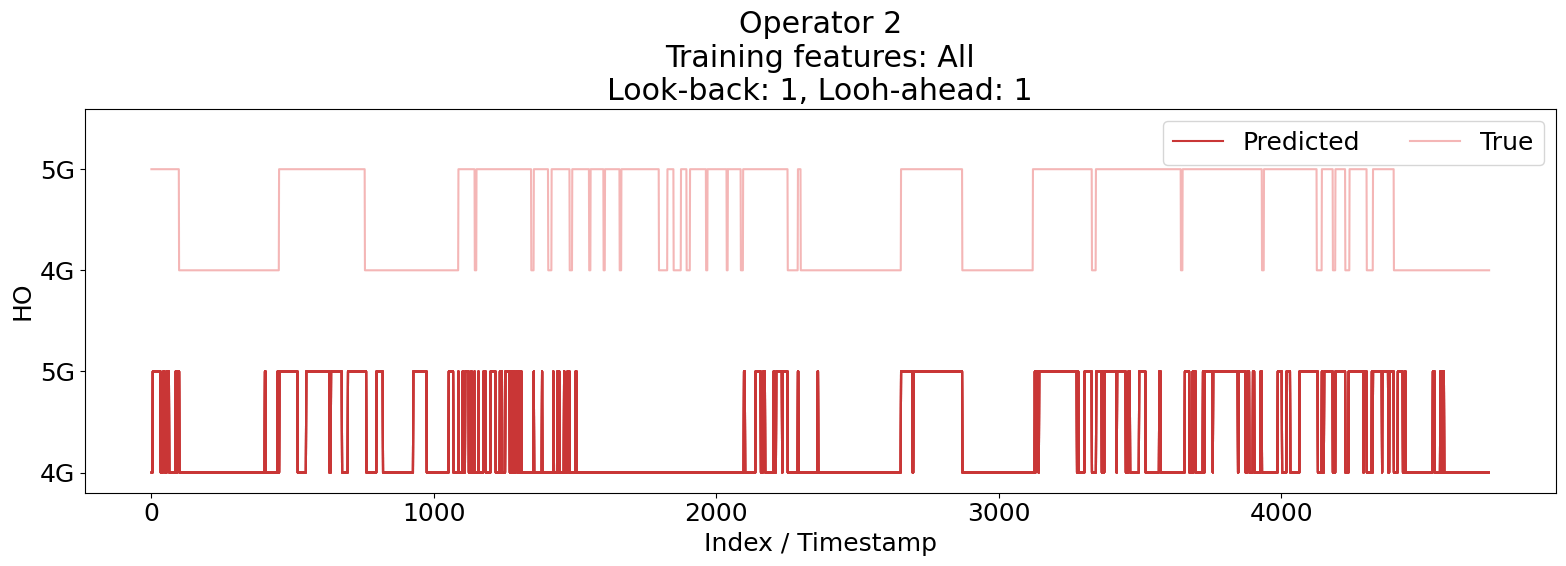

In [12]:
combination = 'All'
comb = x1n1[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, operator=operator, test_train='test', comb=combination, n_steps_in=1, n_steps_out=1)
fig.savefig(r'../latex/plots/lstm_mode/op2_1_look-back_1_look-ahead.pdf')

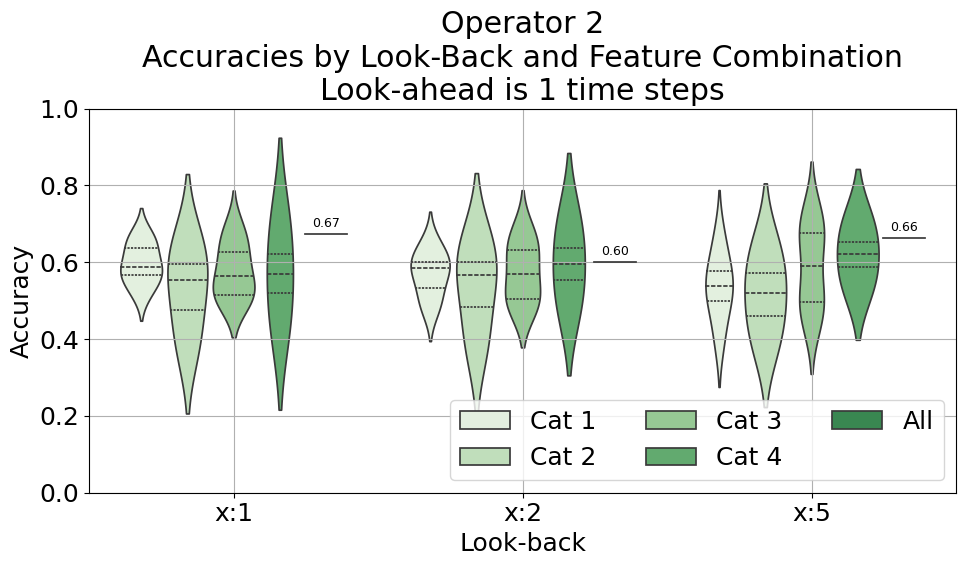

In [121]:
fig = box_lookback(step1_results, n_steps_out=1, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op2_violin_n1.pdf')

In [89]:
n_steps_ins, n_steps_out = [1, 2, 5], 2

step2_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step2_results[f'x:{n_steps_in}'] = temp_results

In [93]:
x1n2 = step2_results['x:1']

x1n2_results = pd.DataFrame.from_dict(x1n2, orient='index')
x1n2_results.reset_index(inplace=True)
x1n2_results.rename(columns={'index': 'Combination'}, inplace=True)
x1n2_results = x1n2_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x1n2_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.601,0.601,1.000,0.492,0.492,1.000
1,SINR,0.508,0.589,0.599,0.611,0.570,0.847
2,RSRQ,0.571,0.598,0.871,0.522,0.507,0.962
3,"RSRP, SINR",0.491,0.597,0.470,0.566,0.562,0.531
4,"RSRP, RSRQ",0.441,0.993,0.071,0.520,0.797,0.032
5,"SINR, RSRQ",0.503,0.597,0.531,0.661,0.614,0.835
6,"RSRP, SINR, RSRQ",0.453,0.571,0.360,0.662,0.664,0.635
7,SSS_RSRP,0.601,0.601,1.000,0.492,0.492,1.000
8,SSS_SINR,0.654,0.815,0.550,0.778,0.803,0.727
9,SSS_RSRQ,0.570,0.863,0.339,0.724,0.897,0.495


In [94]:
x2n2 = step2_results['x:2']

x2n2_results = pd.DataFrame.from_dict(x2n2, orient='index')
x2n2_results.reset_index(inplace=True)
x2n2_results.rename(columns={'index': 'Combination'}, inplace=True)
x2n2_results = x2n2_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x2n2_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.503,0.746,0.262,0.585,0.733,0.246
1,SINR,0.508,0.605,0.521,0.648,0.608,0.804
2,RSRQ,0.543,0.590,0.779,0.502,0.496,0.863
3,"RSRP, SINR",0.479,0.590,0.437,0.658,0.625,0.761
4,"RSRP, RSRQ",0.449,0.989,0.083,0.526,0.849,0.044
5,"SINR, RSRQ",0.497,0.595,0.513,0.674,0.629,0.822
6,"RSRP, SINR, RSRQ",0.489,0.963,0.155,0.548,0.737,0.128
7,SSS_RSRP,0.544,0.987,0.243,0.670,0.988,0.333
8,SSS_SINR,0.643,0.814,0.525,0.795,0.837,0.725
9,SSS_RSRQ,0.564,0.795,0.370,0.740,0.878,0.548


In [95]:
x5n2 = step2_results['x:5']

x5n2_results = pd.DataFrame.from_dict(x5n2, orient='index')
x5n2_results.reset_index(inplace=True)
x5n2_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n2_results = x5n2_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n2_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.600,0.600,1.000,0.492,0.492,1.000
1,SINR,0.504,0.604,0.505,0.653,0.612,0.806
2,RSRQ,0.564,0.587,0.920,0.513,0.503,0.972
3,"RSRP, SINR",0.600,0.600,1.000,0.492,0.492,1.000
4,"RSRP, RSRQ",0.600,0.600,1.000,0.492,0.492,1.000
5,"SINR, RSRQ",0.546,0.615,0.652,0.664,0.607,0.903
6,"RSRP, SINR, RSRQ",0.477,0.566,0.551,0.637,0.600,0.786
7,SSS_RSRP,0.603,0.979,0.346,0.708,0.976,0.417
8,SSS_SINR,0.655,0.826,0.539,0.817,0.843,0.773
9,SSS_RSRQ,0.569,0.791,0.383,0.745,0.877,0.561


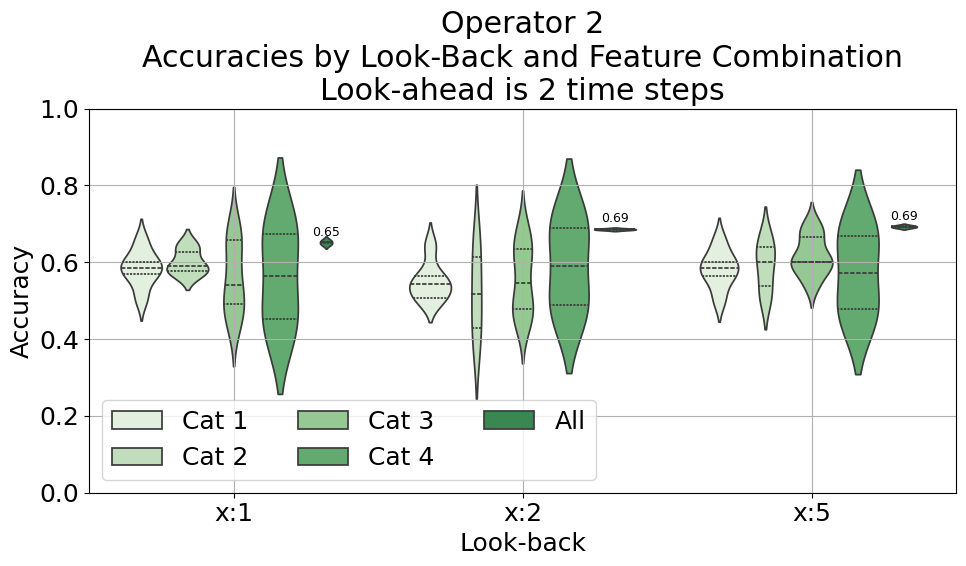

In [122]:
fig = box_lookback(step2_results, n_steps_out=2, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op2_violin_n2.pdf')

In [102]:
n_steps_ins, n_steps_out = [1, 3, 5], 3

step3_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step3_results[f'x:{n_steps_in}'] = temp_results

In [103]:
x1n3 = step3_results['x:1']

x1n3_results = pd.DataFrame.from_dict(x1n3, orient='index')
x1n3_results.reset_index(inplace=True)
x1n3_results.rename(columns={'index': 'Combination'}, inplace=True)
x1n3_results = x1n3_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x1n3_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.399,0.000,0.000,0.508,0.000,0.000
1,SINR,0.509,0.604,0.532,0.631,0.591,0.806
2,RSRQ,0.560,0.595,0.841,0.513,0.503,0.941
3,"RSRP, SINR",0.498,0.597,0.504,0.643,0.602,0.809
4,"RSRP, RSRQ",0.399,0.000,0.000,0.508,0.000,0.000
5,"SINR, RSRQ",0.498,0.597,0.508,0.629,0.593,0.783
6,"RSRP, SINR, RSRQ",0.473,0.589,0.409,0.624,0.599,0.710
7,SSS_RSRP,0.407,1.000,0.014,0.516,0.958,0.017
8,SSS_SINR,0.640,0.809,0.524,0.791,0.835,0.716
9,SSS_RSRQ,0.567,0.905,0.311,0.707,0.922,0.442


In [104]:
x3n3 = step3_results['x:3']

x3n3_results = pd.DataFrame.from_dict(x3n3, orient='index')
x3n3_results.reset_index(inplace=True)
x3n3_results.rename(columns={'index': 'Combination'}, inplace=True)
x3n3_results = x3n3_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x3n3_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.416,0.965,0.029,0.521,1.000,0.027
1,SINR,0.520,0.613,0.546,0.643,0.601,0.820
2,RSRQ,0.510,0.594,0.578,0.560,0.539,0.735
3,"RSRP, SINR",0.601,0.601,1.000,0.492,0.492,1.000
4,"RSRP, RSRQ",0.601,0.601,1.000,0.492,0.492,1.000
5,"SINR, RSRQ",0.519,0.596,0.618,0.639,0.590,0.876
6,"RSRP, SINR, RSRQ",0.525,0.603,0.612,0.667,0.619,0.840
7,SSS_RSRP,0.657,0.712,0.719,0.641,0.595,0.849
8,SSS_SINR,0.654,0.814,0.549,0.785,0.811,0.735
9,SSS_RSRQ,0.573,0.764,0.419,0.737,0.803,0.619


In [105]:
x5n3 = step3_results['x:5']

x5n3_results = pd.DataFrame.from_dict(x5n3, orient='index')
x5n3_results.reset_index(inplace=True)
x5n3_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n3_results = x5n3_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n3_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.468,0.557,0.550,0.605,0.591,0.641
1,SINR,0.507,0.609,0.500,0.648,0.610,0.793
2,RSRQ,0.573,0.592,0.931,0.522,0.508,0.974
3,"RSRP, SINR",0.510,0.598,0.561,0.652,0.609,0.820
4,"RSRP, RSRQ",0.405,0.651,0.018,0.515,0.944,0.016
5,"SINR, RSRQ",0.502,0.589,0.563,0.681,0.624,0.887
6,"RSRP, SINR, RSRQ",0.487,0.582,0.513,0.633,0.597,0.785
7,SSS_RSRP,0.658,0.735,0.674,0.675,0.633,0.806
8,SSS_SINR,0.654,0.808,0.556,0.790,0.805,0.757
9,SSS_RSRQ,0.573,0.818,0.372,0.733,0.883,0.528


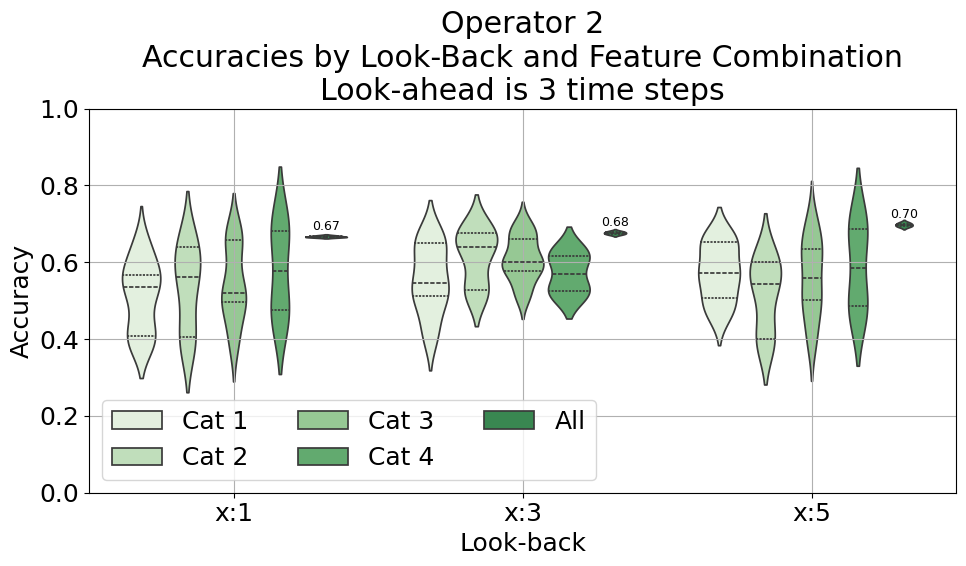

In [123]:
fig = box_lookback(step3_results, n_steps_out=3, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op2_violin_n3.pdf')

In [107]:
n_steps_ins, n_steps_out = [2, 5, 8], 5

step5_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step5_results[f'x:{n_steps_in}'] = temp_results

In [108]:
x2n5 = step5_results['x:2']

x2n5_results = pd.DataFrame.from_dict(x2n5, orient='index')
x2n5_results.reset_index(inplace=True)
x2n5_results.rename(columns={'index': 'Combination'}, inplace=True)
x2n5_results = x2n5_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x2n5_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.490,0.839,0.187,0.549,0.810,0.110
1,SINR,0.515,0.616,0.510,0.648,0.609,0.794
2,RSRQ,0.570,0.598,0.870,0.522,0.508,0.962
3,"RSRP, SINR",0.528,0.601,0.639,0.626,0.581,0.862
4,"RSRP, RSRQ",0.476,0.618,0.336,0.614,0.781,0.302
5,"SINR, RSRQ",0.509,0.610,0.505,0.691,0.647,0.820
6,"RSRP, SINR, RSRQ",0.521,0.599,0.611,0.637,0.594,0.828
7,SSS_RSRP,0.606,0.970,0.356,0.712,0.967,0.430
8,SSS_SINR,0.648,0.808,0.543,0.778,0.805,0.725
9,SSS_RSRQ,0.579,0.762,0.436,0.732,0.783,0.631


In [109]:
x5n5 = step5_results['x:5']

x5n5_results = pd.DataFrame.from_dict(x5n5, orient='index')
x5n5_results.reset_index(inplace=True)
x5n5_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n5_results = x5n5_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n5_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.600,0.600,1.000,0.493,0.493,1.000
1,SINR,0.514,0.607,0.541,0.658,0.614,0.829
2,RSRQ,0.593,0.598,0.982,0.511,0.502,0.989
3,"RSRP, SINR",0.528,0.599,0.647,0.619,0.578,0.841
4,"RSRP, RSRQ",0.543,0.607,0.677,0.569,0.556,0.623
5,"SINR, RSRQ",0.488,0.574,0.576,0.665,0.607,0.904
6,"RSRP, SINR, RSRQ",0.525,0.586,0.709,0.601,0.564,0.845
7,SSS_RSRP,0.400,0.000,0.000,0.507,0.000,0.000
8,SSS_SINR,0.656,0.794,0.577,0.787,0.783,0.787
9,SSS_RSRQ,0.587,0.760,0.456,0.736,0.780,0.648


In [110]:
x8n5 = step5_results['x:8']

x8n5_results = pd.DataFrame.from_dict(x8n5, orient='index')
x8n5_results.reset_index(inplace=True)
x8n5_results.rename(columns={'index': 'Combination'}, inplace=True)
x8n5_results = x8n5_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x8n5_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.579,0.678,0.569,0.422,0.420,0.453
1,SINR,0.531,0.630,0.528,0.630,0.600,0.750
2,RSRQ,0.557,0.586,0.889,0.529,0.512,0.958
3,"RSRP, SINR",0.600,0.600,1.000,0.494,0.494,1.000
4,"RSRP, RSRQ",0.447,0.962,0.081,0.525,0.884,0.044
5,"SINR, RSRQ",0.483,0.579,0.507,0.700,0.642,0.890
6,"RSRP, SINR, RSRQ",0.488,0.575,0.565,0.648,0.603,0.843
7,SSS_RSRP,0.600,0.600,1.000,0.494,0.494,1.000
8,SSS_SINR,0.634,0.782,0.542,0.822,0.846,0.781
9,SSS_RSRQ,0.580,0.780,0.417,0.750,0.841,0.608


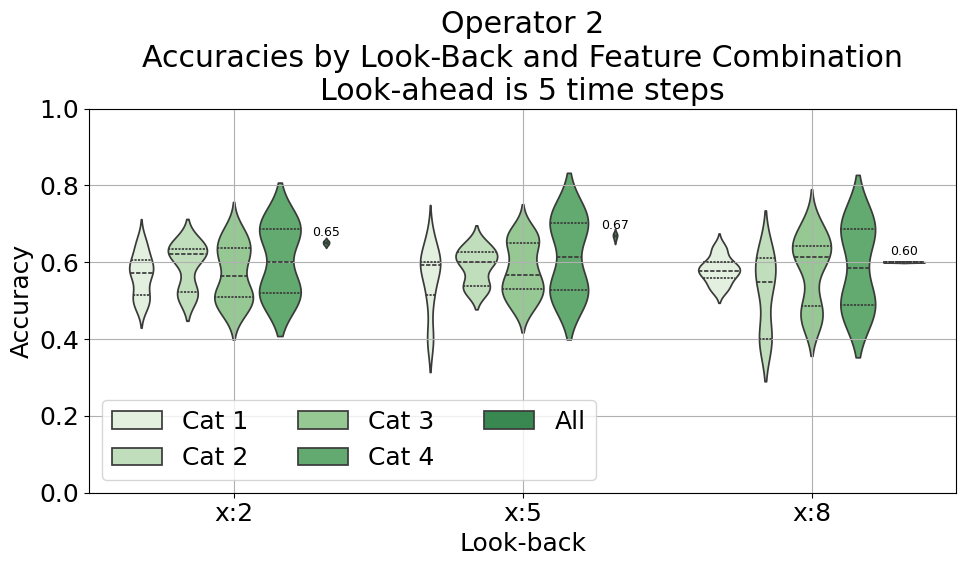

In [124]:
fig = box_lookback(step5_results, n_steps_out=5, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op2_violin_n5.pdf')

In [112]:
n_steps_ins, n_steps_out = [2, 5, 10, 15], 10

step10_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step10_results[f'x:{n_steps_in}'] = temp_results

In [113]:
x2n10 = step10_results['x:2']

x2n10_results = pd.DataFrame.from_dict(x2n10, orient='index')
x2n10_results.reset_index(inplace=True)
x2n10_results.rename(columns={'index': 'Combination'}, inplace=True)
x2n10_results = x2n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x2n10_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.488,0.859,0.177,0.549,0.878,0.100
1,SINR,0.510,0.604,0.536,0.650,0.605,0.838
2,RSRQ,0.569,0.598,0.867,0.524,0.509,0.957
3,"RSRP, SINR",0.522,0.593,0.651,0.615,0.574,0.855
4,"RSRP, RSRQ",0.537,0.592,0.744,0.581,0.554,0.772
5,"SINR, RSRQ",0.568,0.631,0.679,0.599,0.563,0.838
6,"RSRP, SINR, RSRQ",0.508,0.611,0.500,0.639,0.615,0.717
7,SSS_RSRP,0.469,0.931,0.126,0.570,0.957,0.133
8,SSS_SINR,0.641,0.799,0.538,0.773,0.798,0.723
9,SSS_RSRQ,0.562,0.748,0.410,0.728,0.785,0.617


In [114]:
x5n10 = step10_results['x:5']

x5n10_results = pd.DataFrame.from_dict(x5n10, orient='index')
x5n10_results.reset_index(inplace=True)
x5n10_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n10_results = x5n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n10_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.406,1.000,0.010,0.514,1.000,0.016
1,SINR,0.508,0.606,0.516,0.664,0.623,0.813
2,RSRQ,0.593,0.598,0.982,0.513,0.503,0.982
3,"RSRP, SINR",0.552,0.621,0.651,0.624,0.581,0.853
4,"RSRP, RSRQ",0.557,0.619,0.679,0.587,0.580,0.592
5,"SINR, RSRQ",0.520,0.597,0.617,0.681,0.623,0.894
6,"RSRP, SINR, RSRQ",0.515,0.580,0.698,0.607,0.567,0.863
7,SSS_RSRP,0.648,0.822,0.528,0.722,0.800,0.582
8,SSS_SINR,0.631,0.789,0.527,0.796,0.831,0.737
9,SSS_RSRQ,0.568,0.777,0.393,0.737,0.838,0.579


In [115]:
x10n10 = step10_results['x:10']

x10n10_results = pd.DataFrame.from_dict(x10n10, orient='index')
x10n10_results.reset_index(inplace=True)
x10n10_results.rename(columns={'index': 'Combination'}, inplace=True)
x10n10_results = x10n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x10n10_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.453,0.956,0.092,0.526,0.902,0.047
1,SINR,0.480,0.583,0.467,0.671,0.636,0.785
2,RSRQ,0.549,0.590,0.814,0.590,0.553,0.904
3,"RSRP, SINR",0.409,0.842,0.018,0.517,0.900,0.026
4,"RSRP, RSRQ",0.400,0.000,0.000,0.505,0.000,0.000
5,"SINR, RSRQ",0.460,0.574,0.388,0.680,0.673,0.687
6,"RSRP, SINR, RSRQ",0.459,0.555,0.496,0.633,0.594,0.815
7,SSS_RSRP,0.600,0.600,1.000,0.495,0.495,1.000
8,SSS_SINR,0.623,0.787,0.509,0.808,0.839,0.757
9,SSS_RSRQ,0.585,0.737,0.480,0.736,0.763,0.677


In [116]:
x15n10 = step10_results['x:15']

x15n10_results = pd.DataFrame.from_dict(x15n10, orient='index')
x15n10_results.reset_index(inplace=True)
x15n10_results.rename(columns={'index': 'Combination'}, inplace=True)
x15n10_results = x15n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x15n10_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.493,0.648,0.336,0.611,0.763,0.313
1,SINR,0.493,0.595,0.484,0.670,0.638,0.774
2,RSRQ,0.546,0.597,0.742,0.550,0.530,0.816
3,"RSRP, SINR",0.463,0.567,0.439,0.650,0.619,0.767
4,"RSRP, RSRQ",0.554,0.602,0.750,0.575,0.552,0.753
5,"SINR, RSRQ",0.458,0.553,0.500,0.676,0.627,0.856
6,"RSRP, SINR, RSRQ",0.450,0.627,0.202,0.611,0.749,0.323
7,SSS_RSRP,0.401,1.000,0.000,0.504,0.000,0.000
8,SSS_SINR,0.630,0.735,0.596,0.826,0.818,0.834
9,SSS_RSRQ,0.583,0.751,0.453,0.760,0.833,0.645


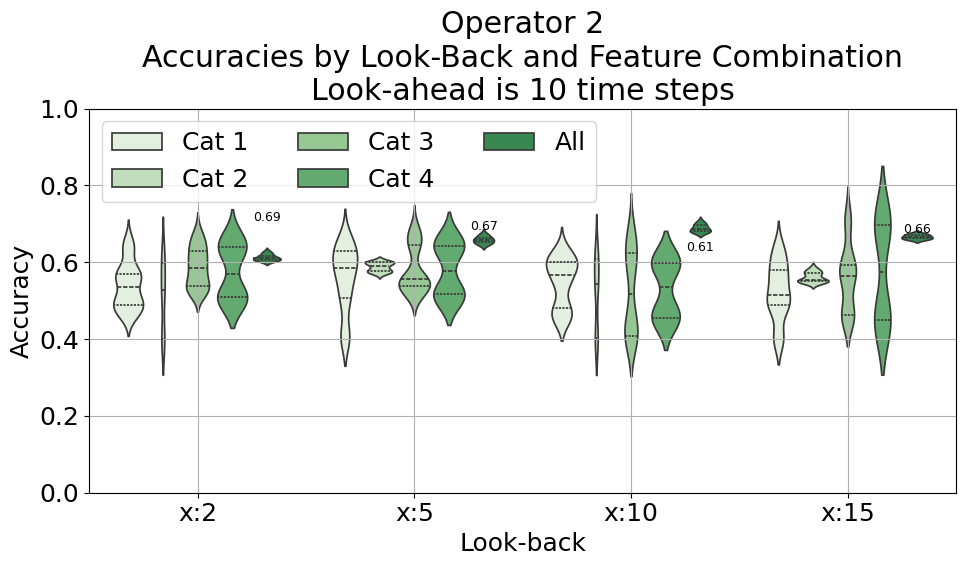

In [125]:
fig = box_lookback(step10_results, n_steps_out=10, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op2_violin_n10.pdf')